In [ ]:
!jupyter nbconvert zfl2019.ipynb --to slides --post serve 

# Land Use Classification and Machine Learning
## ZFL, Bonn March/April 2019
### Mort Canty

http://mortcanty.github.io/src/ 

mort.canty@gmail.com

### Outline
Land cover classification of remote sensing imagery is a task which falls into the general category of pattern recognition. Pattern recognition problems, in turn, are usually approached by developing appropriate machine learning algorithms. Broadly speaking, machine learning involves tasks for which there is no known direct method to compute a desired output from a set of inputs. The strategy adopted is for the computer to learn from a set of representative examples.

In the case of supervised classification, the task can often be seen as one of modeling probability distributions.  This is called the training phase of the classification procedure. Then these probabilities are used to classify all of the pixels in the image, a step  referred to as the generalization phase.

The course will treat three representative models for supervised classification which involve probability estimation: a parametric model (the Bayes maximum likelihood classifier), a nonparametric model (Gaussian kernel classification), and a semiparametric or mixture model (the feed-forward neural network or FFN). In addition statistical methods for accuracy assessment and model comparison will be discussed.

The theory will be illustrated with Python programs for classification and evaluation, both for local processing as well as on the Google Earth Engine. In the case of neural networks, deep learning techniques with TensorFlow will be introduced.

In [1]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
# enable in-line graphics
%matplotlib inline

### The reference ASTER image

In [2]:
!ls imagery | grep AST

AST_20010409
AST_20010409.hdr
AST_20010730
AST_20010730.hdr
AST_20050911
AST_20050911.hdr
AST_20070501
AST_20070501.hdr
AST_20070501_pca_class.tif
AST_20070501_pca_Dnn(tensorflow).tst
AST_20070501_pca_MaxLike.tst
AST_20070501_pca.tfw
AST_20070501_pca.tif
AST_3N
AST_3N.hdr
AST_DEM
AST_DEM.hdr


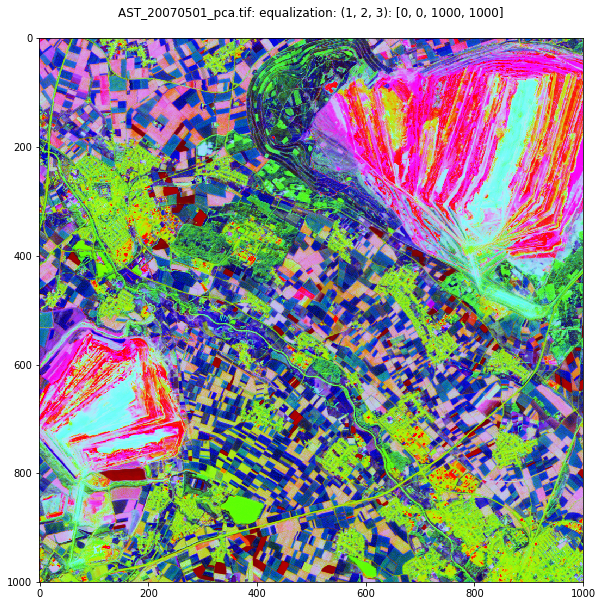

In [4]:
run scripts/dispms -f imagery/AST_20070501_pca.tif -p [1,2,3] -e 4

## Training data acquired on 1.5.2007

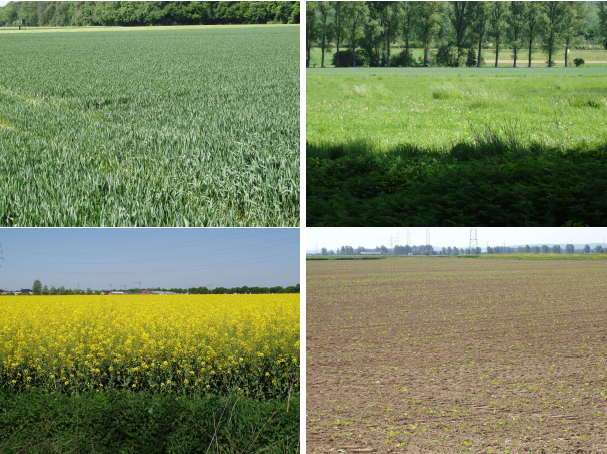

In [1]:
from IPython.display import Image
Image(filename="pngs/fig1.png",width=600,height=600)

The training regions are in ENVI shapefiles in the imagery directory:

In [5]:
!ls imagery | grep train

train_.dbf
train.dbf
train_.evf
train.prj
train.roi
train.shp
train.shx
train.txt


In [6]:
!cat imagery/train.txt | grep 'ROI name'

and these have been uploaded to GEE as a table in the shared Asset

    users/mortcanty/supervisedclassification/train
    
together with the 9-band ASTER PCA image 

    users/mortcanty/supervisedclassification/AST_20070501_pca

Here we sample the training regions to get a feature collection of training data:

In [7]:
import ee
ee.Initialize()

# first 4 principal components of ASTER image
image = ee.Image('users/mortcanty/supervisedclassification/AST_20070501_pca') \
            .select(0,1,2,3)

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])

print trainData.size().getInfo()  
print set(table.aggregate_array('CLASS_NAME').getInfo())

7173
set([u'TAGEBAU [W', u'RAPS [YELL', u'GETREIDE [', u'SIEDLUNG [', u'RUEBEN [CY', u'NADELWALD', u'WASSER [BL', u'LAUBWALD [', u'GEWERBE [M', u'GRAS [RED2'])


## Training data separability
Bayes' Rule
$$
Pr(k\mid g) = { p(g\mid k) Pr(k)\over p(g) }
$$

The Bayes error for a binary classifier:

$$
\epsilon = \int\min[\ Pr(1\mid g),Pr(2\mid g)\ ]p(g)dg = \int\min[\ p(g\mid 1)Pr(1),p(g\mid 2)Pr(2)\ ]dg.
$$

If the two probability densities are assumed to be Gaussian, we get 

$$
\epsilon\le\epsilon_B =\sqrt{Pr(1)Pr(2)}\int \sqrt{p(g\mid 1)p(g\mid 2)}\ dg = \sqrt{Pr(1)Pr(2)}\ e^{-B},
$$

where the Bhattacharyya distance between is:

$$
B = {1\over 8}(\mu_2-\mu_1)^\top \left[{\Sigma_1+\Sigma_2\over 2}\right]^{-1} (\mu_2-\mu_1)
+{1\over 2}\log\left({\left|\Sigma_1+\Sigma_2\right|/2\over \sqrt{|\Sigma_1||\Sigma_2|}}\right).
$$

Larger values of $B$ imply smaller Bayes error. The Jeffries-Matusita separability measure is defined in terms of $B$ as

$$
J = 2(1-e^{-B})
$$

This is a function to calculate the Jeffries-Matusita separability on the GEE:

In [8]:
def jmsep(class1,class2,image,table): 
    ''' Jeffries-Matusita separability '''    
    #  mean and covariance of class1
    table1 = table.filter(ee.Filter.eq('CLASS_ID',str(class1-1)))
    m1 = image.reduceRegion(ee.Reducer.mean(),table1).toArray() 
    s1 = image.toArray().reduceRegion(ee.Reducer.covariance(),table1).toArray()
    #  mean and covariance of class2    
    table2 = table.filter(ee.Filter.eq('CLASS_ID',str(class2-1)))
    m2 = image.reduceRegion(ee.Reducer.mean(),table2).toArray()
    s2 = image.toArray().reduceRegion(ee.Reducer.covariance(),table2,15).toArray()
    #  difference of means     
    m12 = m1.subtract(m2)  
    m12 = ee.Array([m12.toList()]) # makes 2D matrix  
    #  first term in Bhattacharyya distance
    s12i = s1.add(s2).divide(2).matrixInverse()
    B1 = m12.matrixMultiply(s12i.matrixMultiply(m12.matrixTranspose())).divide(8)
    #  second term    
    ds1 = s1.matrixDeterminant()
    ds2 = s2.matrixDeterminant() 
    ds12 = s1.add(s2).matrixDeterminant()
    B2 = ds12.divide(2).divide(ds1.multiply(ds2).sqrt()).log().divide(2)
    #  add them together    
    B = ee.Number(B1.add(B2).project([0]).toList().get(0))
    #  J-M separability
    return ee.Number(1).subtract(ee.Number(1).divide(B.exp())).multiply(2)

In [9]:
print jmsep(5,9,image,table).getInfo()

1.99715676937


Band mean values for the training data, illustrating iteration over an ee.List object

In [10]:
def band_mean(current,prev):
    current = ee.String(current)
    prev = ee.Dictionary(prev)
    trainData = ee.FeatureCollection(prev.get('trainData'))
    class_id = prev.get('class_id')
    means = ee.List(prev.get('means'))
    mu = trainData.filter(ee.Filter.eq('CLASS_ID',class_id)).aggregate_mean(current)
    return ee.Dictionary({ 'trainData':trainData,'class_id':class_id,'means':means.add(mu) })

def class_mean(trainData,class_id,bandNames):
    first = ee.Dictionary({'trainData':trainData,'class_id':str(class_id),'means':ee.List([])})
    return ee.Dictionary(bandNames.iterate(band_mean,first)).get('means')

In [11]:
mu = ee.Array(class_mean(trainData,9,image.bandNames()))
print mu.getInfo()    

[31.329666699089675, 4.0067963564760785, 3.5330487996783466, -0.9069676977568889]


## Bayes Maximum Likeliood Classifier (parametric model)

### Naive Bayes on the GEE

In [ ]:
jet = 'black,blue,cyan,yellow,red,brown'

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])

# rename the class ids in the trainData feature collection from strings to integers
trainData = trainData.remap(['0','1','2','3','4','5','6','7','8','9'],[0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
    
# train a naive Bayes classifier    
classifier = ee.Classifier.continuousNaiveBayes()
trained = classifier.train(trainData,'CLASS_ID',image.bandNames())

# classify the image and display    
classified = image.classify(trained)
url = classified.select('classification').getThumbURL({'min':0,'max':9,'palette':jet})
Image(url=url)

### Gaussian Bayes Maximum Likelihood with the classify.py script

In [ ]:
run scripts/classify -p [1,2,3,4] -a 1 imagery/AST_20070501_pca.tif imagery/train.shp

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" 

## Gauss Kernel Classifier (non-parametric model)

In [ ]:
run scripts/classify -p [1,2,3,4] -a 2 -P imagery/AST_20070501_pca.tif imagery/train.shp

## Feed Forward Neural Network (mixture model)

In [ ]:
Image(filename="pngs/fig2.png",width=600,height=600)

### DNN: mplementation of a FFN in low-level TensorFlow 

"Deep learning is a particular kind of machine learning that achieves great power and ﬂexibility by representing the world as a nested hierarchy of concepts, with each concept deﬁned in relation to simpler concepts, and more abstract representations computed in terms of less abstract ones."

##### TensorFlow is not (yet) available on the GEE

#### Exporting train/test data from GEE to Google Drive for classification with TensorFlow

In [ ]:
import ee
ee.Initialize()

# first 4 principal components of ASTER image
image = ee.Image('users/mortcanty/supervisedclassification/AST_20070501_pca') \
            .select(0,1,2,3)

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])

# a column of random numbers in [0,1]
trainTestData = trainData.randomColumn('rand',seed=12345) 
    
# filter on the random column to split into training and test
# feature collections in the ration of 2:1
trainData = trainTestData.filter(ee.Filter.lt('rand',0.67))
testData = trainTestData.filter(ee.Filter.gte('rand',0.67))

print 'train pixels: %i'%trainData.size().getInfo()
print 'test pixels:  %i'%testData.size().getInfo()    

# Export feature collections as csv files
gdexport = ee.batch.Export.table.toDrive(trainData,description='driveexporttask',folder= 'EarthEngineImages',fileNamePrefix='traindata')    
gdexport.start() 

gdexport = ee.batch.Export.table.toDrive(testData,description='driveexporttask',folder= 'EarthEngineImages',fileNamePrefix='testdata')    
gdexport.start()  

#### < Download the CSV files from Google Drive to myimagery folder>

In [ ]:
!ls myimagery | grep csv

Read in the CSV file as Pandas dataframes

In [ ]:
import pandas as pd

dftrain = pd.read_csv('myimagery/traindata.csv')
dftest = pd.read_csv('myimagery/testdata.csv')
print dftrain.head(5)

Convert relevant columns to numpy arrays

In [ ]:
Gstrn = dftrain.values[:,2:6]
lstrn = dftrain.values[:,1]

Gstst = dftest.values[:,2:6]
lstst = dftest.values[:,1]

print Gstrn.shape
print lstrn.shape
print Gstst.shape
print lstst.shape

#### Digression: tfintro.ipynb

#### Now setup the DNN

In [ ]:
import tensorflow as tf
from datetime import datetime

# tensorflow execution graph

tf.reset_default_graph()

# placeholders
Gs = tf.placeholder(tf.float32,shape=(None,4))
ls = tf.placeholder(tf.int64,shape=(None))
# hidden layer with rectified linear units (relu) 
hidden=tf.layers.dense(Gs,10,activation=tf.nn.relu)
# output layer
logits=tf.layers.dense(hidden,10)
# cross entropy cost function
xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=ls,logits=logits)
cost=tf.reduce_mean(xentropy)
# training algorithm with 0.01 learning rate
optimizer=tf.train.GradientDescentOptimizer(0.01)
training_op=optimizer.minimize(cost)
# variables initializer 
init=tf.global_variables_initializer()
# accuracy evaluation
correct=tf.nn.in_top_k(logits,ls,1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
# saver
saver = tf.train.Saver()
# logger
cost_summary = tf.summary.scalar('COST',cost)

#### Training and testing

In [ ]:
%%time
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = 'tf_logs/run-'+str(now)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())
with tf.Session() as sess:
    init.run()
    for epoch in range(5000):
        if epoch % 200 ==0:
            summary_str = cost_summary.eval(feed_dict={Gs:Gstrn,ls:lstrn})
            file_writer.add_summary(summary_str,epoch)
#        training_op.eval(feed_dict={Gs:Gstrn,ls:lstrn})
        sess.run(training_op,feed_dict={Gs:Gstrn,ls:lstrn})
    acc = accuracy.eval(feed_dict={Gs:Gstst,ls:lstst})
    save_path = saver.save(sess,'imagery/dnn.ckpt')
file_writer.close()
print 'Test accuracy: %f'%acc

In [ ]:
!tensorboard --logdir tf_logs/

#### Prediction, first read in the entire image

In [ ]:
import auxil.readshp as rs
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt
import numpy as np

infile='imagery/AST_20070501_pca.tif'
gdal.AllRegister()
inDataset = gdal.Open(infile,GA_ReadOnly)
# read entire image
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize  
Gs_all = np.zeros((cols*rows,4))
for b in range(4):
    band = inDataset.GetRasterBand(b+1)
    Gs_all[:,b] = band.ReadAsArray(0,0,cols,rows)\
                          .astype(float).ravel()    

#### Now restore the saved model and set up evaluation of the output layer with the full image

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,'imagery/dnn.ckpt')
    Z = logits.eval(feed_dict={Gs:Gs_all})
    cls = np.argmax(Z,1)  

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.reshape(cls/10.0,(rows,cols)),cmap='jet')

### Implementation in high-level TensorFlow (keras)
__Note:__ Here we read the ENVI shapefiles directly

In [ ]:
run scripts/classify -p [1,2,3,4] -a 6 -n -e 1000 -L [10,10,10] imagery/AST_20070501_pca.tif imagery/train.shp

## Convolutional Neural Networks (CNN)

__FFN/DNN for spectral classification__

__CNN for spatial classification (object recognition)__

https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a

### Prepare training/test/validation data

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

def gray_background(img):
    return np.where(img>100,img,100)

# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#x_train = np.array(map(gray_background,x_train))
#x_test = np.array(map(gray_background,x_test))

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# normalize the train/test data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

plt.imshow(x_test[54],cmap='gray',vmin=0,vmax=1)

('x_train shape:', (60000, 28, 28), 'y_train shape:', (60000,))


In [2]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

('x_train shape:', (55000, 28, 28, 1), 'y_train shape:', (55000, 10))
(55000, 'train set')
(5000, 'validation set')
(10000, 'test set')


### Create the model graph structure

In [ ]:
from IPython.display import Image
Image(filename="pngs/fig3.png",width=600,height=600)

In [3]:
model = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
__________

In [2]:
# conv2d: (2 times 2 kernel pixels + 1 bias) times 64 filters
print (2*2 + 1)*64

# conv2d_1: (2 times 2 kernel pixels times 64 filters + 1 bias) times 32 filters
print (2*2*64 + 1)*32

# flatten: 7*7*32
print 7*7*32

#dense
print 256*(1568+1)

# dense_1
print 10*(256+1)

320
8224
1568
401664
2570


#### Compile the model

In [4]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Run the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = 'tf_cnn/run-'+str(now)
checkpointer = ModelCheckpoint(filepath='imagery/model.weights.best.hdf5', verbose = 1, save_best_only=True)
tensorboardlog = TensorBoard(logdir)

model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=5,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer,tensorboardlog])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
54976/55000 [============================>.] - ETA: 0s - loss: 0.6012 - acc: 0.7790
Epoch 00001: val_loss improved from inf to 0.37895, saving model to imagery/model.weights.best.hdf5
55000/55000 [==============================] - 53s 955us/step - loss: 0.6012 - acc: 0.7789 - val_loss: 0.3789 - val_acc: 0.8626
Epoch 2/5
54976/55000 [============================>.] - ETA: 0s - loss: 0.4144 - acc: 0.8496
Epoch 00002: val_loss improved from 0.37895 to 0.32994, saving model to imagery/model.weights.best.hdf5
55000/55000 [==============================] - 52s 948us/step - loss: 0.4144 - acc: 0.8496 - val_loss: 0.3299 - val_acc: 0.8824
Epoch 3/5
54976/55000 [============================>.] - ETA: 0s - loss: 0.3754 - acc: 0.8619
Epoch 00003: val_loss improved from 0.32994 to 0.30632, saving model to imagery/model.weights.best.hdf5
55000/55000 [==============================] - 52s 941us/step - loss: 0.3753 - acc: 0.8619 - val_loss: 0.

In [ ]:
!tensorboard --logdir tf_cnn

### Test the model

In [ ]:
# Load the weights with the best validation accuracy
model.load_weights('imagery/model.weights.best.hdf5')

# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print '\nTest accuracy:', score[1]

# save the model
# model.save('imagery/model.hdf5')

### Apply the model to find  articles of clothing  lost from a flight over Jülich

In [ ]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import auxil.auxil1 as auxil

# make and save a test image
gdal.AllRegister()             
inDataset = gdal.Open('imagery/LE7_20010525',GA_ReadOnly)     
tstimg = auxil.lin2pcstr(inDataset.GetRasterBand(1).ReadAsArray())

for i in range(3):
    for j in range(3):
        ii = np.random.randint(100,900)
        jj = np.random.randint(100,900)
        tstimg[ii:ii+28,jj:jj+28] = np.reshape(255*x_train[np.random.randint(0,5000)],(28,28))

driver = inDataset.GetDriver() 
outDataset = driver.Create('imagery/tstimg',1000,1000,1,GDT_Float32) 
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(tstimg,0,0) 
outBand.FlushCache()
outDataset = None
inDataset = None

In [ ]:
# restore model
model =tf.keras.models.load_model('imagery/model.weights.best.hdf5')

In [ ]:
# read in the test image
infile = 'imagery/tstimg'
gdal.AllRegister()             
inDataset = gdal.Open(infile,GA_ReadOnly)       
imagetst = inDataset.GetRasterBand(1).ReadAsArray()/255.
inDataset = None

In [ ]:
run scripts/dispms -f 'imagery/tstimg' -e 1 

In [ ]:
import sys
classprobimg = np.zeros((1000,1000))
for i in range(14,1000-14):
    if i % 100 == 0:
        print i
    tiles = np.array([np.reshape(imagetst[i-14:i+14,j-14:j+14],(28,28,1)) for j in range(14,1000-14)])
    classprobimg[i,0:1000-28] = map(np.max,model.predict(tiles))

In [ ]:
outDataset = driver.Create('imagery/signal',1000,1000,3,GDT_Float32) 
signal = np.where(classprobimg>0.999,classprobimg,0)
sigimg = np.zeros((3,1000,1000))
sigimg[0,:,:] = signal
for i in range(3):
    outBand = outDataset.GetRasterBand(i+1)
    outBand.WriteArray(sigimg[i,:,:],0,0) 
    outBand.FlushCache()
outDataset = None

In [ ]:
run scripts/dispms -f  imagery/tstimg -e 4 -d [600,0,400,400] -F imagery/signal -E 2 -P [1,2,3] -o 0.5 -D [600,0,400,400]